In [1]:
# Install required libraries
!pip install numpy pandas scikit-learn torch transformers


REQUIRED LIABRARIES

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score
from transformers import AutoTokenizer, TFAutoModel  # if using BioBERT or similar embeddings


PREPARE DATASET

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import pandas as pd

# File path in Google Drive
file_path = '/content/drive/My Drive/data-00007-of-00010'


data = pd.read_csv(file_path, delimiter='\t')

# # Load the file into a DataFrame
# data = pd.read_csv(file_path, delimiter='\t', nrows=100)  # Adjust delimiter as needed
print(data.head())


                           URL  \
MENTION Bayer filter  863044.0   
TOKEN   bluring       905997.0   
        well          863642.0   
        makes         863424.0   
        DarkKhaki     837410.0   

                     ftp://194.44.98.42/UPLOAD/SOFT/delphi/AForge.NET%20Framework-2.2.3/Release/AForge.Imaging.xml  
MENTION Bayer filter          http://en.wikipedia.org/wiki/Bayer_filter                                             
TOKEN   bluring                                                     NaN                                             
        well                                                        NaN                                             
        makes                                                       NaN                                             
        DarkKhaki                                                   NaN                                             


In [6]:
data.describe()

,URL
count,1.454791e+07
mean,5.037379e+04
std,8.219209e+04
min,1.000000e+01
25%,1.442600e+04
50%,2.606100e+04
75%,5.187800e+04
max,9.973540e+05


In [7]:
# Check column names and data types
print(data.info())

# Display a sample of the data
print(data.head(10))


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15606294 entries, ('MENTION', 'Bayer filter') to ('TOKEN', "It's")
Data columns (total 2 columns):
 #   Column                                                                                         Dtype  
---  ------                                                                                         -----  
 0   URL                                                                                            float64
 1   ftp://194.44.98.42/UPLOAD/SOFT/delphi/AForge.NET%20Framework-2.2.3/Release/AForge.Imaging.xml  object 
dtypes: float64(1), object(1)
memory usage: 396.6+ MB
None
                           URL  \
MENTION Bayer filter  863044.0   
TOKEN   bluring       905997.0   
        well          863642.0   
        makes         863424.0   
        DarkKhaki     837410.0   
        user          863302.0   
        enumeration   923873.0   
        elemement     849381.0   
        gives         847098.0   
        diffR       

DATA CLEANING AND PREPROCESSING

In [8]:
print(data.head())
print(data.columns)


                           URL  \
MENTION Bayer filter  863044.0   
TOKEN   bluring       905997.0   
        well          863642.0   
        makes         863424.0   
        DarkKhaki     837410.0   

                     ftp://194.44.98.42/UPLOAD/SOFT/delphi/AForge.NET%20Framework-2.2.3/Release/AForge.Imaging.xml  
MENTION Bayer filter          http://en.wikipedia.org/wiki/Bayer_filter                                             
TOKEN   bluring                                                     NaN                                             
        well                                                        NaN                                             
        makes                                                       NaN                                             
        DarkKhaki                                                   NaN                                             
Index(['URL', 'ftp://194.44.98.42/UPLOAD/SOFT/delphi/AForge.NET%20Framework-2.2.3/Release/AFo

In [9]:
# Reset the MultiIndex
data.reset_index(inplace=True)

# Check the updated structure
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15606294 entries, 0 to 15606293
Data columns (total 4 columns):
 #   Column                                                                                         Dtype  
---  ------                                                                                         -----  
 0   level_0                                                                                        object 
 1   level_1                                                                                        object 
 2   URL                                                                                            float64
 3   ftp://194.44.98.42/UPLOAD/SOFT/delphi/AForge.NET%20Framework-2.2.3/Release/AForge.Imaging.xml  object 
dtypes: float64(1), object(3)
memory usage: 476.3+ MB
None


In [10]:
print(data.columns)

Index(['level_0', 'level_1', 'URL',
       'ftp://194.44.98.42/UPLOAD/SOFT/delphi/AForge.NET%20Framework-2.2.3/Release/AForge.Imaging.xml'],
      dtype='object')


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15606294 entries, 0 to 15606293
Data columns (total 4 columns):
 #   Column                                                                                         Dtype  
---  ------                                                                                         -----  
 0   level_0                                                                                        object 
 1   level_1                                                                                        object 
 2   URL                                                                                            float64
 3   ftp://194.44.98.42/UPLOAD/SOFT/delphi/AForge.NET%20Framework-2.2.3/Release/AForge.Imaging.xml  object 
dtypes: float64(1), object(3)
memory usage: 476.3+ MB


In [12]:
# Rename the columns for easier use
data = data.rename(columns={
    'level_0': 'mention_type',  # Renaming 'level_0' to something more descriptive
    'level_1': 'token',         # Renaming 'level_1' to 'token'
    'URL': 'value',             # Renaming 'URL' to 'value'
    'ftp://194.44.98.42/UPLOAD/SOFT/delphi/AForge.NET%20Framework-2.2.3/Release/AForge.Imaging.xml': 'external_url'  # Shortening the URL
})

# Display the first few rows to confirm changes
print(data.head())


  mention_type         token     value  \
0      MENTION  Bayer filter  863044.0   
1        TOKEN       bluring  905997.0   
2        TOKEN          well  863642.0   
3        TOKEN         makes  863424.0   
4        TOKEN     DarkKhaki  837410.0   

                                external_url  
0  http://en.wikipedia.org/wiki/Bayer_filter  
1                                        NaN  
2                                        NaN  
3                                        NaN  
4                                        NaN  


In [13]:
print(data.columns)


Index(['mention_type', 'token', 'value', 'external_url'], dtype='object')


In [14]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)  # Ensure all columns are shown
print(data.head())


  mention_type         token     value                               external_url
0      MENTION  Bayer filter  863044.0  http://en.wikipedia.org/wiki/Bayer_filter
1        TOKEN       bluring  905997.0                                        NaN
2        TOKEN          well  863642.0                                        NaN
3        TOKEN         makes  863424.0                                        NaN
4        TOKEN     DarkKhaki  837410.0                                        NaN


In [16]:
# Updated cleaning function to handle non-string types
import re
def clean_text(text):
    if isinstance(text, str):  # Proceed only if the text is a string
        text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove non-alphanumeric characters
        text = text.lower().strip()  # Convert to lowercase and remove extra spaces
        return text
    else:
        return ""  # Return an empty string if the value is not a string

# Apply the cleaning function to the 'token' column
data['cleaned_text'] = data['token'].apply(clean_text)

# Display the first few rows to verify the results
print(data.head())


  mention_type         token     value                               external_url  cleaned_text
0      MENTION  Bayer filter  863044.0  http://en.wikipedia.org/wiki/Bayer_filter  bayer filter
1        TOKEN       bluring  905997.0                                        NaN       bluring
2        TOKEN          well  863642.0                                        NaN          well
3        TOKEN         makes  863424.0                                        NaN         makes
4        TOKEN     DarkKhaki  837410.0                                        NaN     darkkhaki


In [17]:
import nltk
from nltk.corpus import stopwords

# Download the stopwords dataset if you haven't already
nltk.download('stopwords')

# Get the English stopwords list
stop_words = set(stopwords.words('english'))

# Remove stopwords from the cleaned text column
data['cleaned_text_no_stopwords'] = data['cleaned_text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

# Display the first few rows to verify the results
print(data[['cleaned_text', 'cleaned_text_no_stopwords']].head())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


   cleaned_text cleaned_text_no_stopwords
0  bayer filter              bayer filter
1       bluring                   bluring
2          well                      well
3         makes                     makes
4     darkkhaki                 darkkhaki


VECTORIZING THE CLEANED DATA

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features based on your needs

# Fit and transform the 'cleaned_text_no_stopwords' column
tfidf_matrix = vectorizer.fit_transform(data['cleaned_text_no_stopwords'])

# Display the shape of the resulting TF-IDF matrix to verify
print(tfidf_matrix.shape)


(15606294, 1000)


In [19]:
print(data.columns)


Index(['mention_type', 'token', 'value', 'external_url', 'cleaned_text', 'cleaned_text_no_stopwords'], dtype='object')


In [20]:
# Assigning the target variable
y = data['mention_type']  # This will be the label used for training


In [21]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into training and testing sets
X = tfidf_matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training and test sets created successfully.")


Training and test sets created successfully.


In [22]:
from sklearn.linear_model import LogisticRegression

# Instantiate the Logistic Regression model
model = LogisticRegression(max_iter=500)  # You can increase max_iter if convergence issues arise

# Train the model
model.fit(X_train, y_train)

print("Baseline model training complete.")


Baseline model training complete.


EVALUATING THE MODEL

In [23]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.2f}")

# Print the classification report
print(classification_report(y_test, y_pred))


Baseline Model Accuracy: 0.73


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     MENTION       0.75      0.27      0.39    785286
       TOKEN       0.72      0.97      0.83   2123823
         URL       0.00      0.00      0.00    212150

    accuracy                           0.73   3121259
   macro avg       0.49      0.41      0.41   3121259
weighted avg       0.68      0.73      0.66   3121259



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# Re-train Logistic Regression with class weights to handle imbalance
model = LogisticRegression(max_iter=500, class_weight='balanced')
model.fit(X_train, y_train)

print("Model training complete with balanced class weights.")


Model training complete with balanced class weights.


In [25]:
from transformers import AutoTokenizer, TFAutoModel

# Load tokenizer and model with from_pt=True to use PyTorch weights
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = TFAutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1", from_pt=True)

print("Model loaded successfully.")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint

Model loaded successfully.


In [ ]:
# import numpy as np

# # Function to generate embeddings for a batch of texts
# def get_batch_bert_embeddings(texts):
#     inputs = tokenizer(texts, return_tensors="tf", truncation=True, padding=True, max_length=128)
#     outputs = model(inputs)
#     return outputs.last_hidden_state[:, 0, :].numpy()  # Extract the CLS token embeddings

# # Split the data into batches
# batch_size = 32  # You can adjust the batch size depending on your system's memory capacity
# embeddings_list = []

# for start_idx in range(0, len(data), batch_size):
#     end_idx = min(start_idx + batch_size, len(data))
#     batch_texts = data['cleaned_text_no_stopwords'][start_idx:end_idx].tolist()

#     # Generate embeddings for the batch and extend the embeddings list
#     batch_embeddings = get_batch_bert_embeddings(batch_texts)
#     embeddings_list.extend(batch_embeddings)

# # Create a new DataFrame column to store the embeddings
# data['bert_embeddings'] = embeddings_list

# print("Embeddings successfully created using batch processing.")


In [28]:
from transformers import AutoTokenizer, TFAutoModel

# Use DistilBERT instead of BioBERT for faster performance
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = TFAutoModel.from_pretrained("distilbert-base-uncased", from_pt=True)

print("DistilBERT model loaded successfully.")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


DistilBERT model loaded successfully.


In [29]:
def get_batch_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="tf", truncation=True, padding=True, max_length=64)
    outputs = model(inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Extract the CLS token embeddings


In [30]:
data_sample = data.sample(100, random_state=42)

# Split the sample data into batches
batch_size = 32  # You can adjust the batch size depending on your system's memory capacity
embeddings_list = []

# Generate embeddings for the sample in batches
for start_idx in range(0, len(data_sample), batch_size):
    end_idx = min(start_idx + batch_size, len(data_sample))
    batch_texts = data_sample['cleaned_text_no_stopwords'][start_idx:end_idx].tolist()

    # Generate embeddings for the batch and extend the embeddings list
    batch_embeddings = get_batch_bert_embeddings(batch_texts)
    embeddings_list.extend(batch_embeddings)

# Create a new column in the sampled DataFrame to store the embeddings
data_sample['bert_embeddings'] = embeddings_list

print("Embeddings successfully created for the sample using optimized settings.")

Embeddings successfully created for the sample using optimized settings.


Train a Classifier Using the Embeddings

In [32]:
# Convert the embeddings into a matrix form
X_embeddings = np.vstack(data_sample['bert_embeddings'].values)

# Use 'mention_type' as the target labels
y = data_sample['mention_type']


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Train a simple Logistic Regression model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.85
              precision    recall  f1-score   support

     MENTION       1.00      0.57      0.73         7
       TOKEN       0.81      1.00      0.90        13

    accuracy                           0.85        20
   macro avg       0.91      0.79      0.81        20
weighted avg       0.88      0.85      0.84        20



ERROR ANALYSIS; CREATE A CONFUSION MATRIX

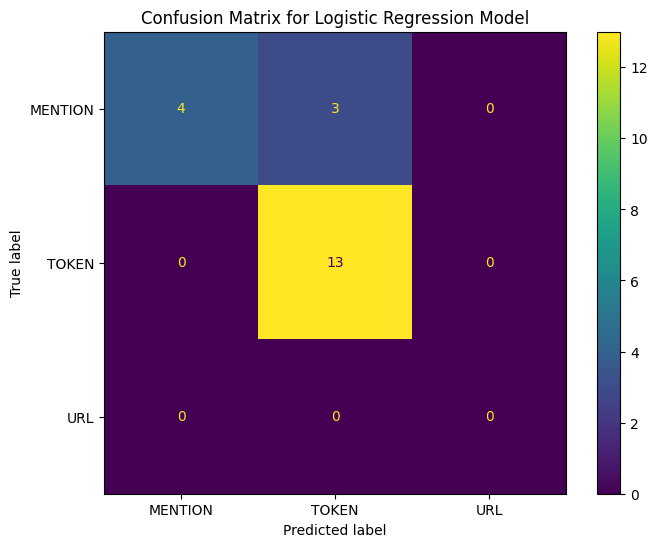

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=model.classes_)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(ax=ax)
plt.title("Confusion Matrix for Logistic Regression Model")
plt.show()


In [35]:
from sklearn.utils import resample

# Separate classes
mention = data[data['mention_type'] == 'MENTION']
token = data[data['mention_type'] == 'TOKEN']
url = data[data['mention_type'] == 'URL']

# Over-sample the 'URL' class to match the size of the largest class
url_oversampled = resample(url, replace=True, n_samples=len(token), random_state=42)

# Combine all classes to form a balanced dataset
data_balanced = pd.concat([mention, token, url_oversampled])

print("Balanced dataset created successfully.")


Balanced dataset created successfully.


In [38]:
from transformers import AutoTokenizer, TFAutoModel

# Use DistilBERT instead of BioBERT for faster performance
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = TFAutoModel.from_pretrained("distilbert-base-uncased", from_pt=True)

print("DistilBERT model loaded successfully.")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


DistilBERT model loaded successfully.


In [39]:
def get_batch_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors="tf", truncation=True, padding=True, max_length=64)
    outputs = bert_model(inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # Extract the CLS token embeddings


In [41]:
# # Assuming the balanced dataset is 'data_balanced' which contains the 'cleaned_text_no_stopwords' column
# batch_size = 32  # Adjust the batch size based on your system's capacity
# embeddings_list = []

# # Generate embeddings for the balanced dataset in batches
# for start_idx in range(0, len(data_balanced), batch_size):
#     end_idx = min(start_idx + batch_size, len(data_balanced))
#     batch_texts = data_balanced['cleaned_text_no_stopwords'][start_idx:end_idx].tolist()

#     # Generate embeddings for the batch and extend the embeddings list
#     batch_embeddings = get_batch_bert_embeddings(batch_texts)
#     embeddings_list.extend(batch_embeddings)

# # Add the embeddings to the balanced DataFrame
# data_balanced['bert_embeddings'] = embeddings_list

# print("Embeddings successfully created for the balanced dataset.")


implementing a more sophisticated model—specifically, an LSTM with an attention mechanism.

In [42]:
import numpy as np
from sklearn.model_selection import train_test_split

# Use embeddings from a sample dataset (assuming embeddings are generated)
X_embeddings = np.vstack(data_sample['bert_embeddings'].values)

# Convert 'mention_type' to numerical form (target variable)
y = data_sample['mention_type']
y = y.map({'MENTION': 0, 'TOKEN': 1, 'URL': 2})  # Mapping labels to numbers

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# Reshape the input data for LSTM (sequence format)
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("Data prepared for LSTM with attention.")


Data prepared for LSTM with attention.


In [43]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import LSTM, Dense

# Attention Layer Definition
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, lstm_output):
        # Compute the alignment scores using a softmax
        attention_scores = tf.nn.softmax(lstm_output, axis=1)
        # Compute the context vector as a weighted sum of the LSTM outputs
        context_vector = tf.reduce_sum(attention_scores * lstm_output, axis=1)
        return context_vector

# Define the LSTM with Attention model
def build_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_output = LSTM(128, return_sequences=True)(inputs)
    attention_output = AttentionLayer()(lstm_output)
    dense_output = Dense(3, activation='softmax')(attention_output)  # Assuming 3 classes: 'MENTION', 'TOKEN', 'URL'

    model = Model(inputs, dense_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
input_shape = (X_train_lstm.shape[1], 1)
model = build_lstm_attention_model(input_shape)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 768, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 768, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer (AttentionLayer)     │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,947 (261.51 KB)

 Trainable params: 66,947 (261.51 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Train the model
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=16, validation_data=(X_test_lstm, y_test))

print("LSTM with Attention model training complete.")


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.4373 - loss: 1.0888 - val_accuracy: 0.6500 - val_loss: 1.0509
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7351 - loss: 0.9822 - val_accuracy: 0.6500 - val_loss: 1.2079
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7446 - loss: 0.8362 - val_accuracy: 0.6500 - val_loss: 0.8249
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7524 - loss: 0.7340 - val_accuracy: 0.6500 - val_loss: 0.7490
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8227 - loss: 0.5621 - val_accuracy: 0.6500 - val_loss: 0.7802
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7168 - loss: 0.8041 - val_accuracy: 0.6500 - val_loss: 0.6793
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7403 - loss: 0.6864 - val_accuracy: 0.6500 - val_loss: 0.6787
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7368 - loss: 0.6744 - val_accuracy: 0.6500 - val_loss: 0.7031

In [45]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on the test set
y_pred_lstm = model.predict(X_test_lstm)
y_pred_labels = np.argmax(y_pred_lstm, axis=1)

# Calculate accuracy
accuracy_lstm = accuracy_score(y_test, y_pred_labels)
print(f"LSTM with Attention Model Accuracy: {accuracy_lstm:.2f}")

# Print the classification report
print(classification_report(y_test, y_pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
LSTM with Attention Model Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.65      1.00      0.79        13

    accuracy                           0.65        20
   macro avg       0.33      0.50      0.39        20
weighted avg       0.42      0.65      0.51        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
# Reduce the size of the balanced dataset to a smaller sample for testing purposes
data_balanced_sample = data_balanced.sample(50, random_state=42)  # Take a sample of 50 rows

# Generate embeddings for this smaller sample
batch_size = 16  # Smaller batch size to avoid memory issues
embeddings_list_sample = []

# Generate embeddings for the sample in batches
for start_idx in range(0, len(data_balanced_sample), batch_size):
    end_idx = min(start_idx + batch_size, len(data_balanced_sample))
    batch_texts = data_balanced_sample['cleaned_text_no_stopwords'][start_idx:end_idx].tolist()

    # Generate embeddings for the batch
    batch_embeddings = get_batch_bert_embeddings(batch_texts)
    embeddings_list_sample.extend(batch_embeddings)

# Add the embeddings to the sampled DataFrame
data_balanced_sample['bert_embeddings'] = embeddings_list_sample

print("Embeddings successfully created for the smaller balanced dataset sample.")


Embeddings successfully created for the smaller balanced dataset sample.


In [49]:
# Prepare the sample data for LSTM
X_embeddings_sample = np.vstack(data_balanced_sample['bert_embeddings'].values)

# Convert 'mention_type' to numerical form (target variable)
y_sample = data_balanced_sample['mention_type']
y_sample = y_sample.map({'MENTION': 0, 'TOKEN': 1, 'URL': 2})

# Train-test split for the smaller sample
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_embeddings_sample, y_sample, test_size=0.2, random_state=42)

# Reshape for LSTM input
X_train_sample_lstm = X_train_sample.reshape((X_train_sample.shape[0], X_train_sample.shape[1], 1))
X_test_sample_lstm = X_test_sample.reshape((X_test_sample.shape[0], X_test_sample.shape[1], 1))

print("Sample data prepared for LSTM training.")


Sample data prepared for LSTM training.


In [51]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import LSTM, Dropout, Dense

# Attention Layer Implementation
class AttentionLayer(layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def call(self, lstm_output):
        # Compute the alignment scores using softmax
        attention_scores = tf.nn.softmax(lstm_output, axis=1)
        # Compute the context vector as a weighted sum of the LSTM outputs
        context_vector = tf.reduce_sum(attention_scores * lstm_output, axis=1)
        return context_vector

# Define the LSTM with Attention model with increased complexity and dropout
def build_improved_lstm_attention_model(input_shape):
    inputs = Input(shape=input_shape)
    lstm_output = LSTM(256, return_sequences=True)(inputs)  # Increased number of units for complexity
    lstm_output = Dropout(0.3)(lstm_output)  # Dropout for regularization
    lstm_output = LSTM(128, return_sequences=True)(lstm_output)  # A second LSTM layer
    attention_output = AttentionLayer()(lstm_output)
    dense_output = Dense(3, activation='softmax')(attention_output)  # Assuming 3 classes: 'MENTION', 'TOKEN', 'URL'

    model = Model(inputs, dense_output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

print("Improved LSTM with Attention model definition complete.")


Improved LSTM with Attention model definition complete.


In [52]:
# Define and build the LSTM with Attention model (again, using the sample dataset)
input_shape_sample = (X_train_sample_lstm.shape[1], 1)
model_sample = build_improved_lstm_attention_model(input_shape_sample)

# Train the model on the sample data
history_sample = model_sample.fit(X_train_sample_lstm, y_train_sample, epochs=10, batch_size=8, validation_data=(X_test_sample_lstm, y_test_sample))

print("Improved LSTM with Attention model training complete for sample data.")


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - accuracy: 0.4201 - loss: 1.0886 - val_accuracy: 0.5000 - val_loss: 1.0411
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5653 - loss: 1.2677 - val_accuracy: 0.5000 - val_loss: 1.0261
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6608 - loss: 0.9639 - val_accuracy: 0.5000 - val_loss: 1.0407
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5861 - loss: 1.0319 - val_accuracy: 0.5000 - val_loss: 1.0351
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.5097 - loss: 1.0484 - val_accuracy: 0.5000 - val_loss: 1.0200
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.5149 - loss: 1.0351 - val_accuracy: 0.5000 - val_loss: 0.9950
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6434 - loss: 0.9641 - val_accuracy: 0.5000 - val_loss: 0.9787
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5618 - loss: 0.9898 - val_accuracy: 0.5000 - val_loss: 0.9763